In [3]:
from tensorflow import keras
from tensorflow.keras.models import Model
import tensorflow as tf
import pickle
from tensorflow.keras.layers import *
from os import listdir
import cv2
import numpy as np
import pickle
from sklearn.model_selection import train_test_split

from sklearn.metrics import f1_score, classification_report
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

In [ ]:
from tensorflow.keras.layers import Input, SeparableConv2D, Concatenate, GlobalAveragePooling2D, Dense, multiply, Activation, AveragePooling2D, BatchNormalization, Dropout

def separable_conv_block(x, filters):
    sep_conv1 = SeparableConv2D(filters=filters, kernel_size=(3, 3), padding='same', activation='relu')(x)
    sep_conv2 = SeparableConv2D(filters=filters, kernel_size=(5, 5), padding='same', activation='relu')(x)
    concatenated = Concatenate()([sep_conv1, sep_conv2])
    pointwise_conv = Conv2D(filters=filters, kernel_size=(1, 1), padding='same', activation='relu')(concatenated)
    batch_normalized = BatchNormalization()(pointwise_conv)
    return batch_normalized

def squeeze_excite_block(x, ratio=16):
    se = GlobalAveragePooling2D()(x)
    se = Dense(units=int(x.shape[-1] / ratio), activation='relu')(se)
    se = Dense(units=x.shape[-1])(se)
    scale_factor = Activation('sigmoid')(se)
    scaled_input = multiply([x, scale_factor])
    return scaled_input

inputs = Input(shape=(224, 224, 3))
#block1+2
block1 = separable_conv_block(inputs, filters=16)
block2 = separable_conv_block(block1, filters=32)
a = Concatenate()([block1, block2])
b = AveragePooling2D()(a)

# Squeeze & Excite Block 1
se = squeeze_excite_block(b, ratio=4)  

#3+4
block3 = separable_conv_block(se, filters=64)
block4 = separable_conv_block(block3, filters=128)
c = Concatenate()([block3, block4])
d = Concatenate()([se, c])
Avg2 = AveragePooling2D()(d)

#5+6
block5 = separable_conv_block(Avg2, filters=128)
block6 = separable_conv_block(block5, filters=256)
cc2 = Concatenate()([block5, block6])
Avg56 = AveragePooling2D()(cc2)

# Squeeze & Excite Block 2
se2 = squeeze_excite_block(Avg56, ratio=4)  
#7+8
block7 = separable_conv_block(se2, filters=512)
block8 = separable_conv_block(block7, filters=1024)
cc3 = Concatenate()([block7, block8])
Avg78 = AveragePooling2D()(cc3)
cc6 = Concatenate()([cc3, se2])
Avg5 = AveragePooling2D()(Avg2)
cc7 = Concatenate()([cc6, Avg5])
Avg6 = AveragePooling2D(pool_size=(4, 4))(cc7)

global_avg_pool = GlobalAveragePooling2D()(Avg6)
# Dropout layer
dropout_layer = Dropout(0.5)(global_avg_pool)
# Output layer
outputs = Dense(50, activation='softmax')(dropout_layer)

model = Model(inputs, outputs)
model.summary()


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 separable_conv2d_48 (Separ  (None, 224, 224, 16)         91        ['input_4[0][0]']             
 ableConv2D)                                                                                      
                                                                                                  
 separable_conv2d_49 (Separ  (None, 224, 224, 16)         139       ['input_4[0][0]']             
 ableConv2D)                                                                                      
                                                                                            

In [6]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

def load_data():
    file = open('/kaggle/input/finaldata/pollen50_full_au.data', 'rb')
    (pixels, labels) = pickle.load(file)
    file.close()
    print(pixels.shape)
    print(labels.shape)
    return pixels, labels

X, y = load_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape)
print(y_train.shape)

# Thêm ModelCheckpoint callback
checkpoint_callback = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
batch_size = 16

# Biên soạn và huấn luyện mô hình
history = model.fit(X_train, y_train, epochs=50, batch_size=batch_size, validation_data=(X_test, y_test), callbacks=[checkpoint_callback])

# Lưu mô hình cuối cùng
model.save('final_model.h5')

# Đọc lại mô hình tốt nhất
best_model = load_model('best_model.h5')

# Đánh giá mô hình tốt nhất trên tập test
results_best = best_model.evaluate(X_test, y_test)
print('Best Test loss: {:4f}'.format(results_best[0]))
print('Best Test accuracy: {:4f}'.format(results_best[1]))

# Đọc lại và đánh giá mô hình cuối cùng
final_model = load_model('final_model.h5')
results_final = final_model.evaluate(X_test, y_test)
print('Final Test loss: {:4f}'.format(results_final[0]))
print('Final Test accuracy: {:4f}'.format(results_final[1]))


(8595, 224, 224, 3)
(8595, 50)
(6876, 224, 224, 3)
(6876, 50)
Epoch 1/50
430/430 [==============================] - ETA: 0s - loss: 1.1679 - accuracy: 0.6341
Epoch 1: val_accuracy improved from -inf to 0.52356, saving model to best_model.h5
430/430 [==============================] - 122s 243ms/step - loss: 1.1679 - accuracy: 0.6341 - val_loss: 1.7053 - val_accuracy: 0.5236
Epoch 2/50
430/430 [==============================] - ETA: 0s - loss: 0.9143 - accuracy: 0.7090
Epoch 2: val_accuracy improved from 0.52356 to 0.74346, saving model to best_model.h5
430/430 [==============================] - 99s 231ms/step - loss: 0.9143 - accuracy: 0.7090 - val_loss: 0.8419 - val_accuracy: 0.7435
Epoch 3/50
430/430 [==============================] - ETA: 0s - loss: 0.7816 - accuracy: 0.7419
Epoch 3: val_accuracy did not improve from 0.74346
430/430 [==============================] - 99s 231ms/step - loss: 0.7816 - accuracy: 0.7419 - val_loss: 3.3374 - val_accuracy: 0.3176
Epoch 4/50
430/430 [=======

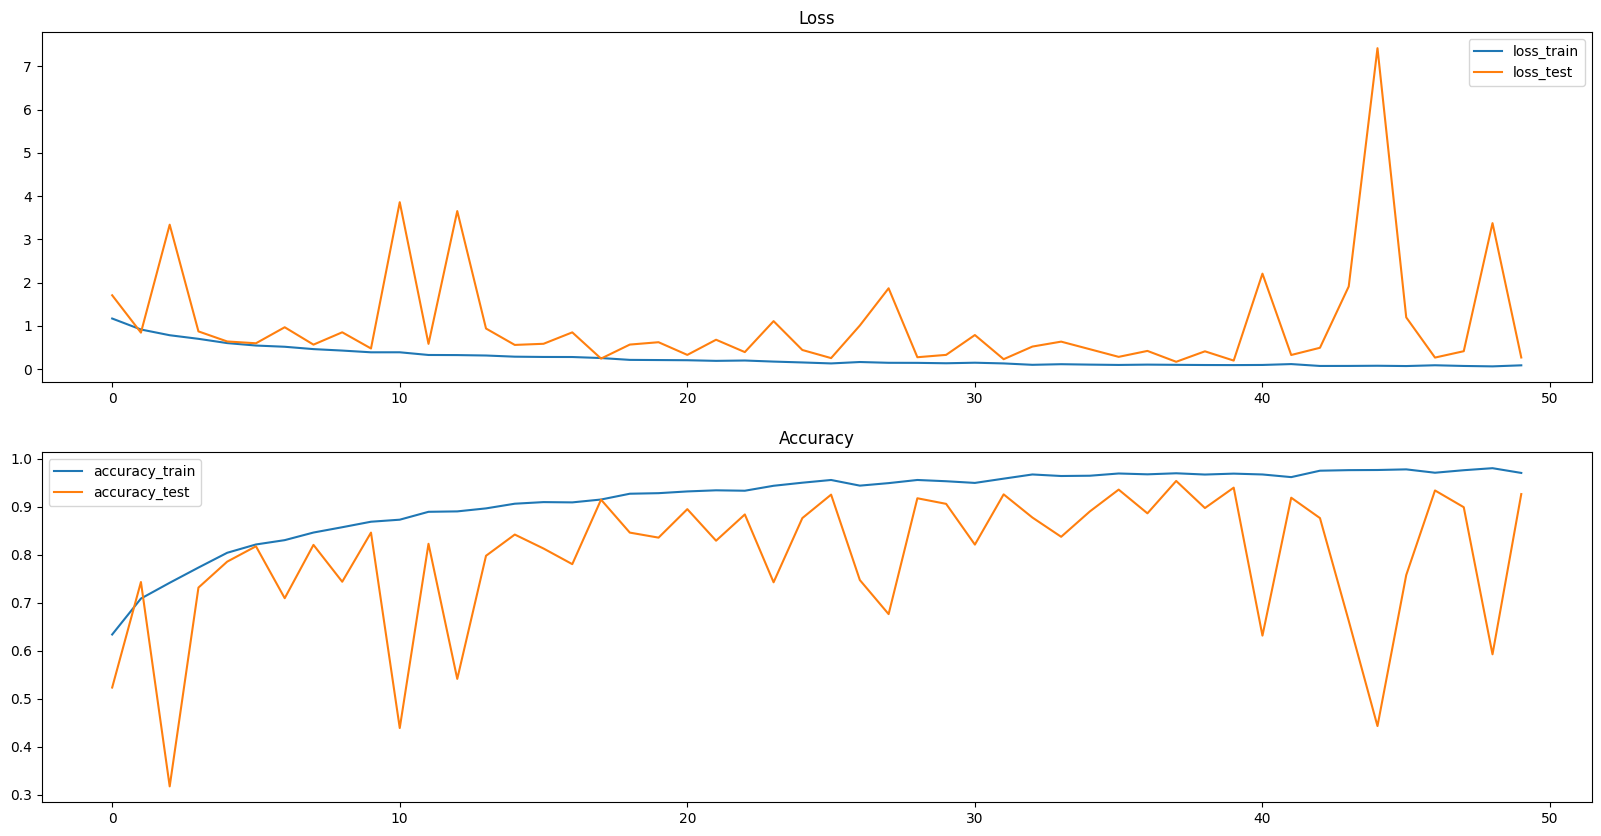

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))

# Biểu đồ Loss và Accuracy
plt.subplot(211)
plt.title('Loss')
plt.plot(history.history['loss'], label='loss_train')
plt.plot(history.history['val_loss'], label='loss_test')
plt.legend()

# Biểu đồ Accuracy
plt.subplot(212)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='accuracy_train')
plt.plot(history.history['val_accuracy'], label='accuracy_test')
plt.legend()

plt.show()

In [10]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Đánh giá mô hình tốt nhất trên tập test
y_pred_best = best_model.predict(X_test)
y_pred_classes_best = np.argmax(y_pred_best, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Classification report (bao gồm F1)
print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes_best))

# Confusion Matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes_best)
print("Confusion Matrix:")
print(conf_matrix)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Accuracy
accuracy = accuracy_score(y_true_classes, y_pred_classes_best)
print(f"Accuracy: {accuracy:.4f}")

# Precision
precision = precision_score(y_true_classes, y_pred_classes_best, average='weighted')
print(f"Precision: {precision:.4f}")

# Recall
recall = recall_score(y_true_classes, y_pred_classes_best, average='weighted')
print(f"Recall: {recall:.4f}")

# F1 Score
f1 = f1_score(y_true_classes, y_pred_classes_best, average='weighted')
print(f"F1 Score: {f1:.4f}")


54/54 [==============================] - 7s 129ms/step
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.93      0.96        41
           1       0.97      0.90      0.94        41
           2       0.92      0.97      0.95        36
           3       0.97      0.88      0.92        32
           4       0.93      0.98      0.95        41
           5       0.97      0.97      0.97        30
           6       1.00      1.00      1.00        40
           7       0.91      0.97      0.94        33
           8       1.00      0.98      0.99        48
           9       0.98      1.00      0.99        43
          10       0.97      1.00      0.98        30
          11       1.00      1.00      1.00        27
          12       0.97      1.00      0.99        38
          13       0.96      0.93      0.95        29
          14       0.97      0.91      0.94        34
          15       1.00      0.96      0.98        28
   

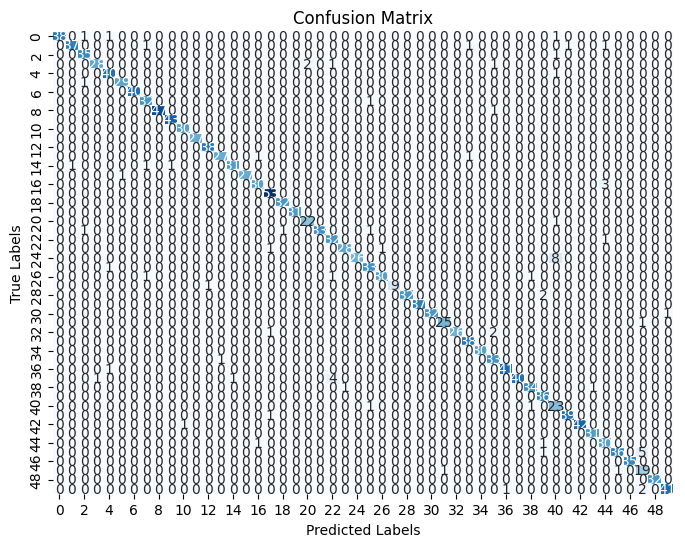

In [11]:
import seaborn as sns

# Plot Confusion Matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

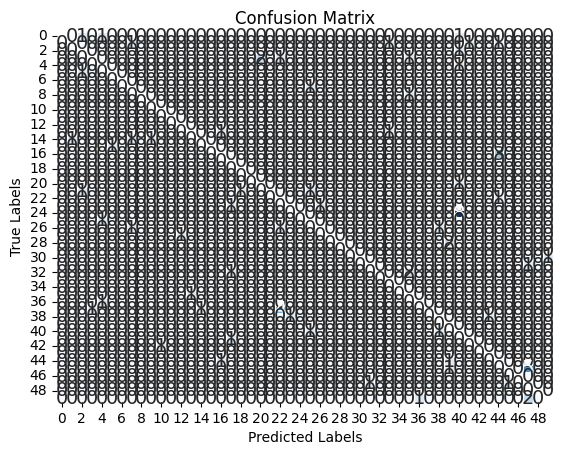

Error Rate for class 0: 0.0732
Error Rate for class 1: 0.0976
Error Rate for class 2: 0.0278
Error Rate for class 3: 0.1250
Error Rate for class 4: 0.0244
Error Rate for class 5: 0.0333
Error Rate for class 6: 0.0000
Error Rate for class 7: 0.0303
Error Rate for class 8: 0.0208
Error Rate for class 9: 0.0000
Error Rate for class 10: 0.0000
Error Rate for class 11: 0.0000
Error Rate for class 12: 0.0000
Error Rate for class 13: 0.0690
Error Rate for class 14: 0.0882
Error Rate for class 15: 0.0357
Error Rate for class 16: 0.0909
Error Rate for class 17: 0.0000
Error Rate for class 18: 0.0000
Error Rate for class 19: 0.0000
Error Rate for class 20: 0.0435
Error Rate for class 21: 0.0833
Error Rate for class 22: 0.0303
Error Rate for class 23: 0.0667
Error Rate for class 24: 0.2353
Error Rate for class 25: 0.0294
Error Rate for class 26: 0.0909
Error Rate for class 27: 0.1000
Error Rate for class 28: 0.0588
Error Rate for class 29: 0.0000
Error Rate for class 30: 0.0303
Error Rate for cla

In [12]:
import seaborn as sns
import numpy as np

# Get the diagonal elements (correct predictions)
correct_predictions = np.diag(conf_matrix)

# Get the total samples for each true class
total_samples_per_class = conf_matrix.sum(axis=1)

# Calculate the error rate for each class
error_rate_per_class = 1 - correct_predictions / total_samples_per_class.astype(float)

# Replace NaN values (which occur when the total_samples_per_class is zero) with zero
error_rate_per_class = np.nan_to_num(error_rate_per_class)

# Create a mask to highlight misclassifications
mask = np.zeros_like(conf_matrix)
mask[np.arange(len(conf_matrix)), np.arange(len(conf_matrix))] = 1

# Set different color for misclassifications
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, mask=mask, linewidths=.5, annot_kws={"size": 14})
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Display error rates for each class
for i, error_rate in enumerate(error_rate_per_class):
    print(f"Error Rate for class {i}: {error_rate:.4f}")


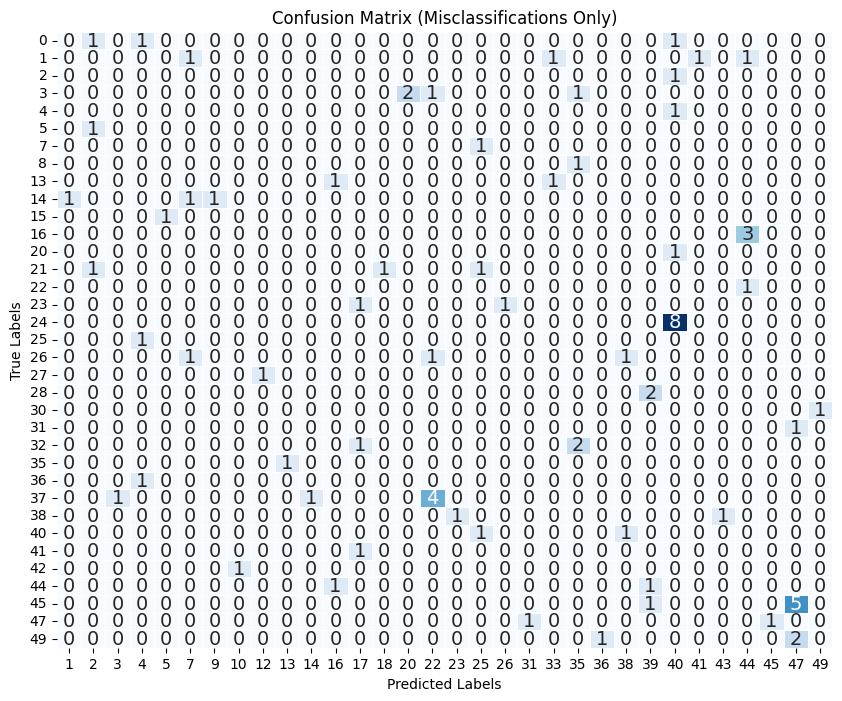

The two classes most frequently misclassified are 24 and 40 with 8 misclassifications.


In [15]:
import seaborn as sns
import numpy as np
import pandas as pd
# Get the indices of the misclassifications
misclassified_indices = np.where(y_true_classes != y_pred_classes_best)[0]

# Create a DataFrame to store the misclassifications
misclassified_df = pd.DataFrame({'True': y_true_classes[misclassified_indices],
                                  'Predicted': y_pred_classes_best[misclassified_indices]})

# Create a cross-tabulation of the misclassifications
confusion_matrix_df = pd.crosstab(misclassified_df['True'], misclassified_df['Predicted'], rownames=['True'], colnames=['Predicted'])

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix_df, annot=True, fmt="d", cmap="Blues", cbar=False, linewidths=.5, annot_kws={"size": 14})
plt.title("Confusion Matrix (Misclassifications Only)")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Identify the class pair with the highest number of misclassifications
max_misclassifications = confusion_matrix_df.values.max()
most_confused_classes = np.where(confusion_matrix_df.values == max_misclassifications)

class1 = confusion_matrix_df.index[most_confused_classes[0][0]]
class2 = confusion_matrix_df.columns[most_confused_classes[1][0]]

print(f"The two classes most frequently misclassified are {class1} and {class2} with {max_misclassifications} misclassifications.")
